In [1]:
!pip install easyocr

  Using cached easyocr-1.7.2-py3-none-any.whl.metadata (10 kB)
  Using cached scikit_image-0.25.2-cp313-cp313-win_amd64.whl.metadata (14 kB)
  Using cached python_bidi-0.6.6-cp313-cp313-win_amd64.whl.metadata (5.0 kB)
  Using cached pyclipper-1.3.0.post6-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached ninja-1.11.1.4-py3-none-win_amd64.whl.metadata (5.0 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached easyocr-1.7.2-py3-none-any.whl (2.9 MB)
Using cached ninja-1.11.1.4-py3-none-win_amd64.whl (296 kB)
   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
    --------------------------------------- 0.8/38.9 MB 3.6 MB/s eta 0:00:11
   - -------------------------------------- 1.3/38.9 MB 3.2 MB/s eta 0:00:12
   -- ------------------------------------- 2.6/38.9 MB 4.4 MB/s eta 0:00:09
   ---- ----------------------------------- 3.9/38.9 MB 5.0 MB/s eta 0:00:08
   -----

# Image File


image 1/1 D:\ML - Projects\Two-wheeler-number-plate\data\test\images\3_20250527_125549_full_jpg.rf.8367c4d8607703bf3d8f5dca02d1d4f4.jpg: 384x640 1 License_plate, 43.3ms
Speed: 14.3ms preprocess, 43.3ms inference, 30.1ms postprocess per image at shape (1, 3, 384, 640)
🚘 Detected Plate Number: 27580


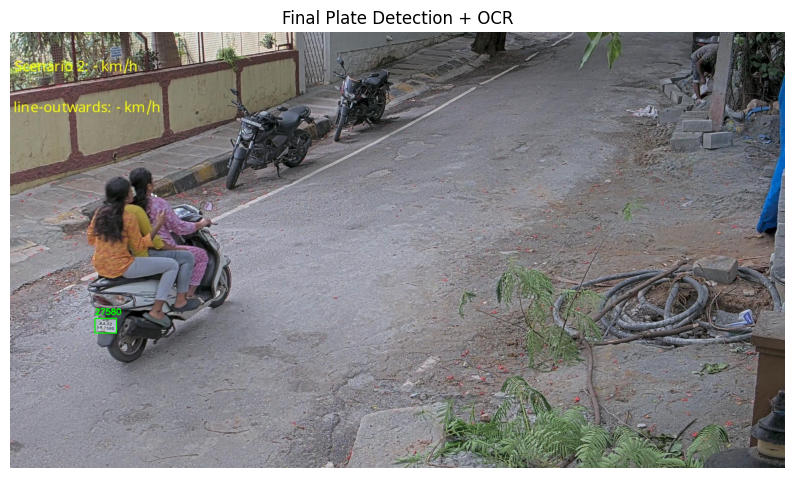

In [9]:
import cv2
import torch
import easyocr
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np

# Load model
model = YOLO('best.pt')

# OCR reader
reader = easyocr.Reader(['en'])

# Load test image
image_path = "data/test/images/3_20250527_125549_full_jpg.rf.8367c4d8607703bf3d8f5dca02d1d4f4.jpg"
img = cv2.imread(image_path)

# Inference
results = model.predict(image_path)

# Process detections
for r in results:
    boxes = r.boxes
    for box in boxes:
        # Get bounding box
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        conf = float(box.conf[0])
        
        if conf < 0.5:
            continue  # Skip low-confidence detections

        # Crop detected plate
        cropped = img[y1:y2, x1:x2]

        # Apply OCR
        ocr_result = reader.readtext(cropped)

        # Join lines and filter out noise
        detected_text = []
        for (bbox, text, score) in ocr_result:
            if score > 0.4 and len(text.strip()) >= 4:  # Filter stickers etc.
                detected_text.append(text.strip())

        if detected_text:
            full_plate = " ".join(detected_text)
            print("🚘 Detected Plate Number:", full_plate)

            # Draw box + label on image
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(img, full_plate, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

# Show final image
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Final Plate Detection + OCR")
plt.show()


# Test Video File

In [2]:
import cv2
import torch
import easyocr
import numpy as np
from ultralytics import YOLO

# Load YOLO model
model = YOLO('best.pt')

# Initialize OCR
reader = easyocr.Reader(['en'])

# Input video path
video_path = "test.mp4"  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

# Get video width/height
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Output video setup
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("output_video.mp4", fourcc, fps, (width, height))

# Frame counter (optional)
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # YOLO prediction
    results = model.predict(source=frame, conf=0.4, verbose=False)

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = float(box.conf[0])
            if conf < 0.5:
                continue

            # Crop the plate
            plate_crop = frame[y1:y2, x1:x2]

            # First OCR attempt
            ocr_result = reader.readtext(plate_crop)
            texts = [text.replace(" ", "").strip() for (_, text, score) in ocr_result if score > 0.4 and len(text.strip()) >= 4]

            # Retry with grayscale if empty
            if not texts:
                gray = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (3, 3), 0)
                _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                ocr_retry = reader.readtext(thresh)
                texts = [text.replace(" ", "").strip() for (_, text, score) in ocr_retry if score > 0.4 and len(text.strip()) >= 4]

            if texts:
                plate_number = "".join(texts)
                print(f"🚘 Frame {frame_count}: {plate_number}")

                # Draw box and label
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, plate_number, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Write annotated frame
    out.write(frame)
    frame_count += 1

# Cleanup
cap.release()
out.release()
print("✅ Saved output video as: output_video.mp4")


🚘 Frame 174: AP2Q
🚘 Frame 177: AP2Q
🚘 Frame 179: AP2Q
🚘 Frame 181: BF7560
🚘 Frame 182: BF7560
🚘 Frame 183: AP29BF7560
🚘 Frame 184: BF7560
🚘 Frame 185: AP29
🚘 Frame 186: BF7586
🚘 Frame 187: AP29BF7566
🚘 Frame 188: AP29BF7566
🚘 Frame 189: BF7566
🚘 Frame 190: BF7566
🚘 Frame 191: BF7566
🚘 Frame 192: BF7566
🚘 Frame 193: BF7506
🚘 Frame 194: AP29BF7506
🚘 Frame 195: BF7506
🚘 Frame 196: AP29BF7506
🚘 Frame 197: BF7566
🚘 Frame 198: AP29DF7500
🚘 Frame 199: BF7506
🚘 Frame 200: AP29BF7500
🚘 Frame 202: AP29
🚘 Frame 203: BF7508
🚘 Frame 206: BF7568
🚘 Frame 208: BF7508
🚘 Frame 209: 7566
🚘 Frame 210: AP29
🚘 Frame 211: AP29BE7566
🚘 Frame 212: AP29
🚘 Frame 218: 4P29
🚘 Frame 220: BF7566
🚘 Frame 222: BF7566
🚘 Frame 488: tterstech
🚘 Frame 489: tterstecl=
🚘 Frame 490: ttersteck
🚘 Frame 494: ttersteck
🚘 Frame 495: ttersteck
🚘 Frame 496: ttersteck
🚘 Frame 497: tterstock
🚘 Frame 498: tterstock
🚘 Frame 499: ttersteck
🚘 Frame 500: tterstock
🚘 Frame 501: Jtterstock
🚘 Frame 502: tterstock
🚘 Frame 503: tterstock
🚘 Fra